<a href="https://colab.research.google.com/github/dogukartal/IBM_AI_Labs/blob/main/AI%20Capstone%20Project%20with%20Deep%20Learning/PyTorch/Crack_Detection_In_Buildings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crack Detection in Buildings
---

## Imports and Auxiliary Functions

In [ ]:
!pip install skillsnetwork

In [ ]:
from PIL import Image
from matplotlib.pyplot import imshow
import pandas
import matplotlib.pylab as plt
import os
import glob
import skillsnetwork
import torch
from torch import optim
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import time

In [ ]:
# Plotting Function
def show_data(data_sample, shape = (28, 28)):
    plt.imshow(data_sample[0].numpy().reshape(shape), cmap='gray')
    plt.title('y = ' + data_sample[1])

##Data

In [ ]:
# skillsnetwork.prepare is a command that's used to download a zip file, unzip it and store it in a specified directory
directory = "/resources/data"
if not os.path.exists(directory):
    os.makedirs(directory)
await skillsnetwork.prepare("https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip", path = "/resources/data", overwrite=True)

  0%|          | 0/40000 [00:00<?, ?it/s]

Saved to '../resources/data'


In [ ]:
negative_file_path = os.path.join(directory, "Negative")
os.listdir(negative_file_path)[0:3] # We can find the all the file in the directory using the function os.listdir

['09857.jpg', '18366.jpg', '14813.jpg']

In [ ]:
# Full path of the image
[os.path.join(negative_file_path, file) for file in os.listdir(negative_file_path)][0:3]

['/resources/data/Negative/09857.jpg',
 '/resources/data/Negative/18366.jpg',
 '/resources/data/Negative/14813.jpg']

In [ ]:
# Checking the type
print("test.jpg".endswith(".jpg"))
print("test.mpg".endswith(".jpg"))

True
False


In [ ]:
negative_files = [os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path) if file.endswith(".jpg")]
negative_files.sort()
negative_files[0:3]

['/resources/data/Negative/00001.jpg',
 '/resources/data/Negative/00002.jpg',
 '/resources/data/Negative/00003.jpg']

In [ ]:
positive_file_path = os.path.join(directory, "Positive")
positive_files = [os.path.join(positive_file_path,file) for file in  os.listdir(positive_file_path) if file.endswith(".jpg")]
positive_files.sort()
positive_files[0:3]

['/resources/data/Positive/00001.jpg',
 '/resources/data/Positive/00002.jpg',
 '/resources/data/Positive/00003.jpg']

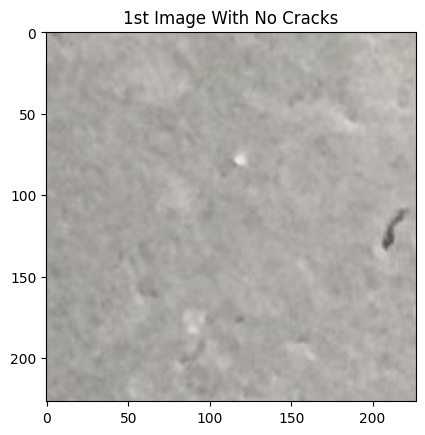

In [ ]:
# We can open an image using the Image module in the PIL library
image1 = Image.open(negative_files[0])
plt.imshow(image1)
plt.title("1st Image With No Cracks")
plt.show()

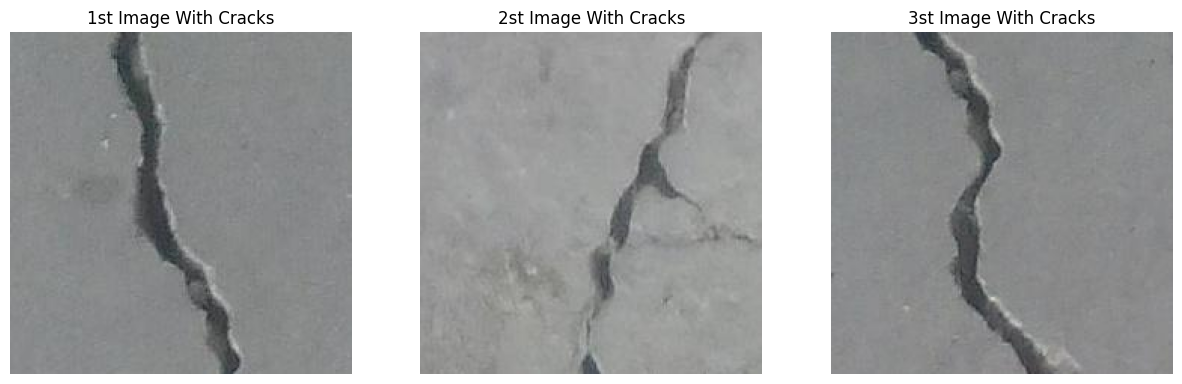

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    image = Image.open(positive_files[i])
    axes[i].imshow(image)
    axes[i].set_title(f"{i+1}st Image With Cracks")
    axes[i].axis('off')
plt.show()

In [ ]:
number_of_samples = len(positive_files) + len(negative_files)

Y = torch.zeros([number_of_samples])
Y = Y.type(torch.LongTensor)
# Set even elements to class one, odd elements to class zero
Y[::2]=1
Y[1::2]=0
Y[:5]

tensor([1, 0, 1, 0, 1])

In [ ]:
all_files = []
for i in range(len(positive_files)):
    all_files.append(positive_files[i])
    all_files.append(negative_files[i])

for i in range(4):
    print(all_files[i])

/resources/data/Positive/00001.jpg
/resources/data/Negative/00001.jpg
/resources/data/Positive/00002.jpg
/resources/data/Negative/00002.jpg


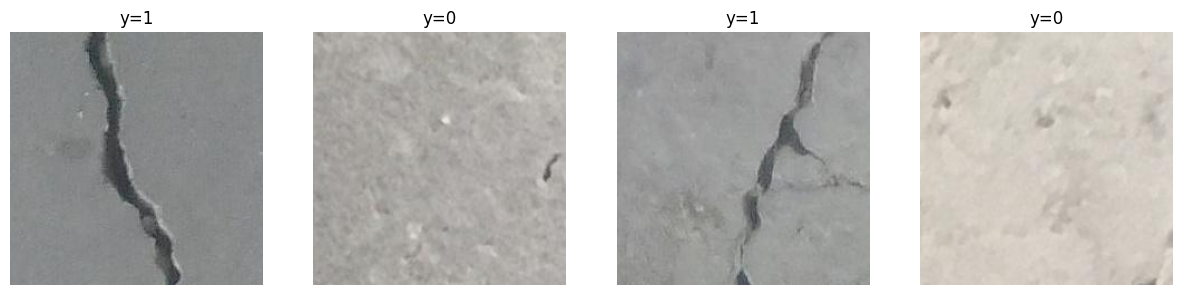

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i, (y, file) in enumerate(zip(Y, all_files[0:4])):
    axes[i].imshow(Image.open(file))
    axes[i].set_title("y="+str(y.item()))
    axes[i].axis('off')
plt.show()

In [ ]:
# Split the data into training and validation parts
train=False

if train:
    all_files = all_files[:30000]
    Y = Y[:30000]
else:
    all_files = all_files[30000:]
    Y = Y[30000:]

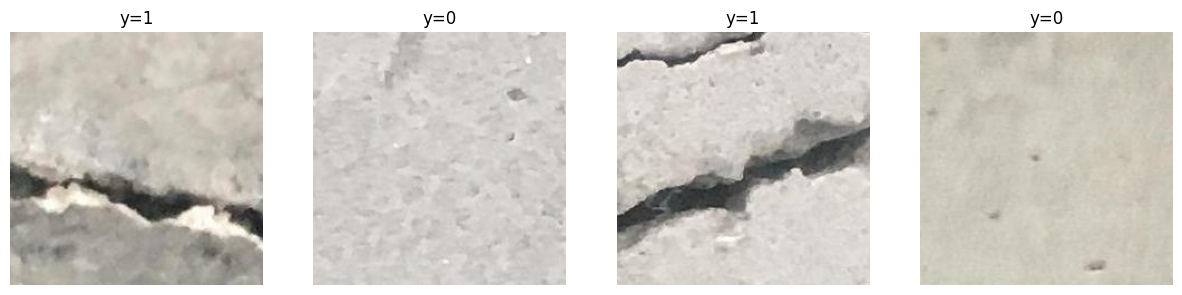

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i, (y, file) in enumerate(zip(Y, all_files[0:4])):
    axes[i].imshow(Image.open(file))
    axes[i].set_title("y="+str(y.item()))
    axes[i].axis('off')
plt.show()

In [ ]:
class Dataset(Dataset):
    def __init__(self,transform=None,train=True):
        directory="/resources/data"
        positive="Positive"
        negative="Negative"

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in  os.listdir(positive_file_path) if file.endswith(".jpg")]
        positive_files.sort()
        negative_files=[os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path) if file.endswith(".jpg")]
        negative_files.sort()

        number_of_samples = len(positive_files) + len(negative_files)

        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files
        self.transform = transform
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0

        if train:
            self.all_files = self.all_files[:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files = self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        image=Image.open(self.all_files[idx])
        y=self.Y[idx]
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)
        return image, y

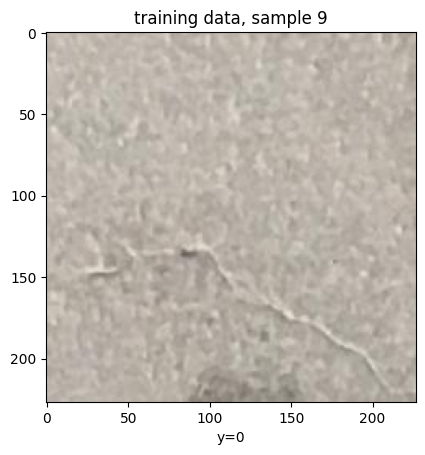

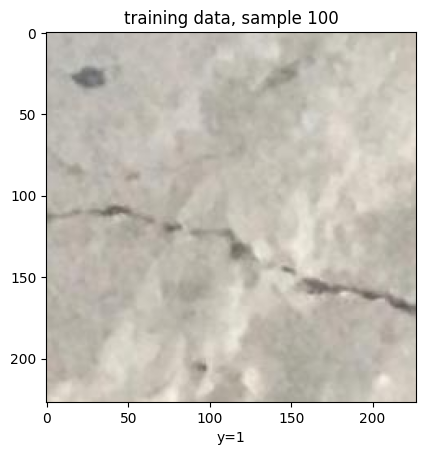

In [ ]:
# Create the training dataset object
dataset = Dataset(train=True)
samples = [9, 100]

for sample in samples:
    plt.imshow(dataset[sample][0])
    plt.xlabel("y="+str(dataset[sample][1].item()))
    plt.title("training data, sample {}".format(int(sample)))
    plt.show()

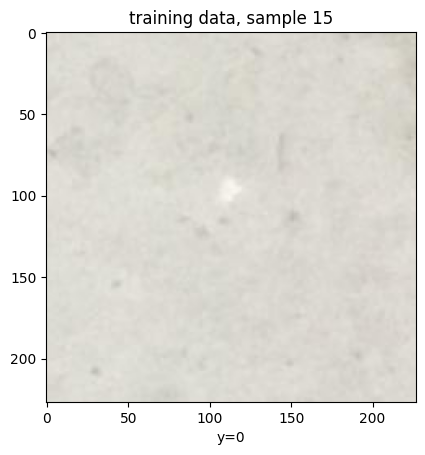

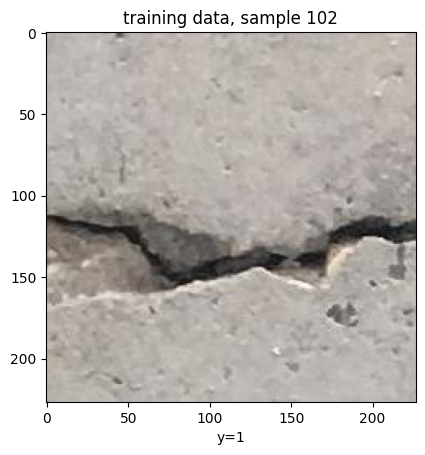

In [ ]:
# Create the validation dataset object
dataset = Dataset(train=False)
samples = [15, 102]

for sample in samples:
    plt.imshow(dataset[sample][0])
    plt.xlabel("y="+str(dataset[sample][1].item()))
    plt.title("training data, sample {}".format(int(sample)))
    plt.show()

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

dataset_train=Dataset(transform=transform,train=True)
dataset_val=Dataset(transform=transform,train=False)

In [ ]:
dataset_train[0][0].shape

torch.Size([3, 227, 227])

## Training Loop

In [ ]:
class SoftmaxModel(nn.Module):
    def __init__(self, input_size):
        super(SoftmaxModel, self).__init__()
        self.linear = nn.Linear(input_size, 2)

    def forward(self, x):
        return self.linear(x)

# Hyperparameters
learning_rate = 0.1
momentum = 0.1
batch_size = 5
epochs = 5
torch.manual_seed(0)
size_of_image = 3*227*227 # Example input size. Update with correct size

# Model, Loss, and Optimizer
model = SoftmaxModel(size_of_image)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# DataLoaders
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

# Training loop
max_accuracy = 0

for epoch in range(epochs):
    # Training
    model.train()
    for images, labels in train_loader:
        images = images.view(-1, size_of_image)  # Flatten images
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.view(-1, size_of_image)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    max_accuracy = max(max_accuracy, accuracy)
    print(f'Epoch [{epoch+1}/{epochs}], Validation Accuracy: {accuracy:.4f}')


print(f"Maximum validation accuracy achieved: {max_accuracy:.4f}")

Epoch [1/5], Validation Accuracy: 0.8365
Epoch [2/5], Validation Accuracy: 0.8376
Epoch [3/5], Validation Accuracy: 0.5063
Epoch [4/5], Validation Accuracy: 0.8233
Epoch [5/5], Validation Accuracy: 0.8463
Maximum validation accuracy achieved: 0.8463


## Pre-trained Model

In [ ]:
model = models.resnet18(pretrained=True)

# Set requires_grad to False for all parameters
for param in model.parameters():
    param.requires_grad = False

# resnet18 is used to classify 1000 different objects; as a result, the last layer has 1000 outputs.  The 512 inputs come from the fact that the previously hidden layer has 512 outputs.

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2) # 2 classes

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
device = torch.device("cuda")

criterion = nn.CrossEntropyLoss()

train_loader = DataLoader(dataset_train, batch_size=100, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=100, shuffle=False)

optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad], lr=0.001)

model = model.to(device)

n_epochs = 1
loss_list = []
accuracy_list = []
correct = 0
N_test = len(dataset_val)
N_train = len(dataset_train)
start_time = time.time()
size_of_image = 3*227*227

for epoch in range(n_epochs):
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()

    model.eval()
    correct = 0
    for x_test, y_test in val_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        z = model(x_test)
        _, yhat = torch.max(z.data, 1)
        correct += (yhat == y_test).sum().item()

    accuracy = correct / N_test
    accuracy_list.append(accuracy)

    print(f'Epoch [{epoch + 1}/{n_epochs}], Validation Accuracy: {accuracy:.4f}')

print(f"Maximum validation accuracy achieved: {max(accuracy_list):.4f}")
print("Time taken: ", time.time() - start_time)

Epoch [1/1], Validation Accuracy: 0.9914
Maximum validation accuracy achieved: 0.9914
Time taken:  114.33445334434509


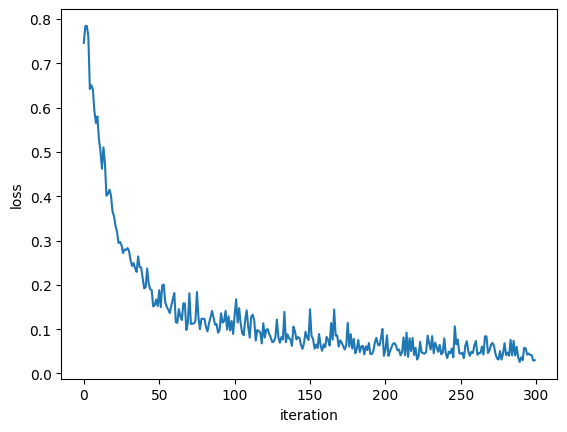

In [ ]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

In [ ]:
# Finding the misclassified samples
misclassified_samples = []
model.eval()
with torch.no_grad():
    for i, (images, labels) in enumerate(val_loader):
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)

        for j in range(len(labels)):
            if predicted[j] != labels[j]:
                misclassified_samples.append((i * val_loader.batch_size + j, predicted[j].item(), labels[j].item()))
                if len(misclassified_samples) == 4:
                    break  # Stop after finding the first four
        if len(misclassified_samples) == 4:
            break

for idx, pred, actual in misclassified_samples:
    print(f"sample {idx}, yhat tensor([{pred}]) y ([{actual}])")

sample 94, yhat tensor([0]) y ([1])
sample 142, yhat tensor([0]) y ([1])
sample 451, yhat tensor([1]) y ([0])
sample 624, yhat tensor([0]) y ([1])
